# Predicting Stock Movements by Analyzing News Data

## Importing Packages

In [1]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

# options

pd.set_option('display.max_columns', None)

## Preparing the News Data

In [2]:
# import news data

df_news = pd.read_csv('data/news_data.csv')
df_news.info()

C:\Users\nicol\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823480 entries, 0 to 823479
Data columns (total 48 columns):
TIMESTAMP_UTC           823480 non-null object
RPNA_DATE_UTC           823480 non-null object
RPNA_TIME_UTC           823480 non-null object
RP_ENTITY_ID            823480 non-null object
ENTITY_TYPE             823480 non-null object
ENTITY_NAME             823480 non-null object
POSITION_NAME           5568 non-null object
RP_POSITION_ID          5568 non-null object
COUNTRY_CODE            823480 non-null object
RELEVANCE               823480 non-null int64
TOPIC                   45300 non-null object
GROUP                   45300 non-null object
TYPE                    45300 non-null object
SUB_TYPE                21440 non-null object
PROPERTY                14679 non-null object
EVALUATION_METHOD       0 non-null float64
MATURITY                0 non-null float64
CATEGORY                45300 non-null object
ESS                     45300 non-null float64
AES            

In [3]:
# change formats

df_news['TICKER'] = df_news['COMPANY'].str[3:]
df_news['TIMESTAMP_UTC'] = pd.to_datetime(df_news['TIMESTAMP_UTC'], utc = True)
df_news['RPNA_DATE_UTC'] = df_news['TIMESTAMP_UTC'].dt.date
df_news['RPNA_TIME_UTC'] = df_news['TIMESTAMP_UTC'].dt.time

In [4]:
# convert UTC to Eastern Standard Time

df_news['TIMESTAMP_EST'] = df_news['TIMESTAMP_UTC'].dt.tz_convert('America/New_York')
df_news['RPNA_DATE_EST'] = df_news['TIMESTAMP_EST'].dt.date
df_news['RPNA_TIME_EST'] = df_news['TIMESTAMP_EST'].dt.time

# get next market day for every observation (news) according to the US trading calendar

from pandas.tseries.offsets import CustomBusinessDay

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay, \
    USLaborDay, USThanksgivingDay

class USTradingCalendar(AbstractHolidayCalendar):
    rules = [Holiday('NewYearsDay', month = 1, day = 1, observance = nearest_workday),
             USMartinLutherKingJr,
             USPresidentsDay,
             GoodFriday,
             USMemorialDay,
             Holiday('USIndependenceDay', month = 7, day = 4, observance = nearest_workday),
             USLaborDay,
             USThanksgivingDay,
             Holiday('Christmas', month = 12, day = 25, observance = nearest_workday)]

bday_us = CustomBusinessDay(calendar = USTradingCalendar())
nasdaq_close = '16:00:00'

df_news['NEXT_MARKET_DATE'] = pd.to_datetime(np.where(df_news['RPNA_TIME_EST'] > pd.to_datetime(nasdaq_close).time(),
                                                      df_news['RPNA_DATE_EST'] + bday_us,
                                                      df_news['RPNA_DATE_EST'] + 0 * bday_us))
df_news['NEXT_MARKET_CLOSE'] = (df_news['NEXT_MARKET_DATE'] + pd.Timedelta(nasdaq_close)).dt.tz_localize('America/New_York')
df_news['TIME_TO_CLOSE'] = df_news['NEXT_MARKET_CLOSE'] - df_news['TIMESTAMP_EST']

'''
the algortihm is working as intended: the stock market was closed from 1st to 3rd January 
-> next market day on 4th January
'''

df_news[['TIMESTAMP_EST', 'NEXT_MARKET_DATE', 'NEXT_MARKET_CLOSE', 'TIME_TO_CLOSE']].head(5)


,TIMESTAMP_EST,NEXT_MARKET_DATE,NEXT_MARKET_CLOSE,TIME_TO_CLOSE
0,2016-01-01 05:30:01.663000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,3 days 10:29:58.337000
1,2016-01-01 05:44:40.104000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,3 days 10:15:19.896000
2,2016-01-03 18:35:51.992000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 21:24:08.008000
3,2016-01-04 00:08:02.003000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 15:51:57.997000
4,2016-01-04 02:05:01.705000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 13:54:58.295000


## Preparing the Market Data

In [5]:
# import market data

df_market = pd.read_csv('data/djia.csv')
df_market.head(1)

,gvkey,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,trfd,exchg
0,1447,1,4/1/2016,AXP,AMERICAN EXPRESS CO,9228601.0,67.59,68.18,66.77,68.09,2.417612,11


In [6]:
# change formats

df_market['datadate'] = pd.to_datetime(df_market['datadate'],
                                       dayfirst = True)

In [7]:
# compute stock return and volatility

df_market['dreturn'] = np.log(df_market.prccd / df_market.prcod)
df_market['dvar'] = ((np.log(df_market.prchd) - np.log(df_market.prcld))**2) / 4 * np.log(2) #Applying the Parkinson (1980) H-L measure
df_market['dvol'] = np.sqrt(df_market.dvar)
df_market['dreturn_flag'] = np.where(df_market['dreturn'] >= 0, 1, -1)

In [8]:
market_return=pd.read_csv('data/gspc.csv')
market_return['mkt_return'] = np.log(market_return.Close / market_return.Open)
market_return=market_return[['Date','mkt_return']]
market_return.columns=['datadate','mkt_return']
market_return['datadate'] = pd.to_datetime(market_return['datadate'])
market_return.head(1)

,datadate,mkt_return
0,2015-12-31,-0.008113


In [9]:
df_market=pd.merge(df_market, market_return,how='left',on='datadate')
df_market.head(1)

,gvkey,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,trfd,exchg,dreturn,dvar,dvol,dreturn_flag,mkt_return
0,1447,1,2016-01-04,AXP,AMERICAN EXPRESS CO,9228601.0,67.59,68.18,66.77,68.09,2.417612,11,-0.00737,0.000076,0.008699,-1,-0.01261


In [10]:
#remove row if closing price or market return is missing
df_market = df_market[np.isfinite(df_market['prcod'])]
df_market = df_market[np.isfinite(df_market['mkt_return'])]

#### Calculating Beta

In [11]:
#get covariance
grouped = df_market.groupby('conm')
group_cov=grouped.apply(lambda x: x['dreturn'].cov(x['mkt_return']))
group_cov=pd.DataFrame(data=group_cov)
group_cov.columns = ['cov']
group_cov.reset_index(inplace=True)

#get market variance
market_var=(df_market.groupby('conm')['mkt_return'].var())
market_var=pd.DataFrame(data=market_var)
market_var.columns = ['var']
market_var.reset_index(inplace=True)

merged_df=pd.merge(group_cov, market_var,how='left',on='conm')
#merged_df

merged_df['beta']=merged_df['cov']/merged_df['var']
merged_df

,conm,cov,var,beta
0,3M CO,0.000033,0.000041,0.794666
1,AMERICAN EXPRESS CO,0.000034,0.000041,0.833967
2,APPLE INC,0.000038,0.000041,0.927551
3,BOEING CO,0.000044,0.000041,1.067496
4,CATERPILLAR INC,0.000048,0.000041,1.172869
5,CHEVRON CORP,0.000032,0.000041,0.784118
6,CISCO SYSTEMS INC,0.000042,0.000041,1.014859
7,COCA-COLA CO,0.000019,0.000041,0.450555
8,DISNEY (WALT) CO,0.000027,0.000041,0.647995
9,EXXON MOBIL CORP,0.000024,0.000041,0.575956


In [12]:
df_market=pd.merge(df_market, merged_df,how='left',on='conm')

In [13]:
#average market return over 2016-2018 period
averagereturn=market_return["mkt_return"].mean()

In [14]:
#compute abnormal return
df_market['exp_return']=df_market['beta']*df_market['mkt_return']
df_market['abnormal_return']=df_market['dreturn']-df_market['exp_return']
df_market['abnormal_return_flag'] = np.where(df_market['abnormal_return'] >= 0, 1, -1)
df_market.head(1)

,gvkey,iid,datadate,tic,conm,cshtrd,prccd,prchd,prcld,prcod,trfd,exchg,dreturn,dvar,dvol,dreturn_flag,mkt_return,cov,var,beta,exp_return,abnormal_return,abnormal_return_flag
0,1447,1,2016-01-04,AXP,AMERICAN EXPRESS CO,9228601.0,67.59,68.18,66.77,68.09,2.417612,11,-0.00737,0.000076,0.008699,-1,-0.01261,0.000034,0.000041,0.833967,-0.010516,0.003146,1


## Joining News and Market Data

In [15]:
# join news data and market data on market date and company

df = pd.merge(df_news,df_market , how = 'inner',
              left_on = ['NEXT_MARKET_DATE', 'TICKER'],
              right_on = ['datadate', 'tic'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785719 entries, 0 to 785718
Data columns (total 78 columns):
TIMESTAMP_UTC           785719 non-null datetime64[ns, UTC]
RPNA_DATE_UTC           785719 non-null object
RPNA_TIME_UTC           785719 non-null object
RP_ENTITY_ID            785719 non-null object
ENTITY_TYPE             785719 non-null object
ENTITY_NAME             785719 non-null object
POSITION_NAME           5150 non-null object
RP_POSITION_ID          5150 non-null object
COUNTRY_CODE            785719 non-null object
RELEVANCE               785719 non-null int64
TOPIC                   42546 non-null object
GROUP                   42546 non-null object
TYPE                    42546 non-null object
SUB_TYPE                20285 non-null object
PROPERTY                13939 non-null object
EVALUATION_METHOD       0 non-null float64
MATURITY                0 non-null float64
CATEGORY                42546 non-null object
ESS                     42546 non-null float64
AE

## Data Cleaning

In [16]:
# drop columns with no explanatory worth

drop = ['ENTITY_TYPE', 'RP_POSITION_ID', 'COUNTRY_CODE','TIMESTAMP_EST','RPNA_DATE_EST','RPNA_TIME_EST',
        'TIME_TO_CLOSE','RPNA_DATE_UTC','RPNA_TIME_UTC','ENTITY_NAME', 'EVALUATION_METHOD', 'ENS_KEY',
        'G_ENS_KEY', 'EVENT_SIMILARITY_KEY', 'RP_STORY_ID', 'PRODUCT_KEY', 'COMPANY', 'ISIN', 'BER', 'ANL_CHG',
        'TICKER', 'NEXT_MARKET_DATE', 'NEXT_MARKET_CLOSE', 'gvkey', 'iid', 'datadate', 'tic', 'conm', 'cshtrd',
        'prccd', 'prchd', 'prcld', 'prcod', 'trfd', 'exchg', 'RP_ENTITY_ID','cov','var','beta','exp_return']
df = df.drop(drop, axis = 1)

In [17]:
# show missing data in rows

missing = (df.isnull().sum(axis = 1) / df.isnull().count(axis = 1)).sort_values(ascending = False)
missing_rows = pd.concat([missing], axis = 1, keys = ['Missing'])
drop_rows = missing_rows[missing_rows['Missing'] > 0.25]
drop_rows.count()

Missing    743173
dtype: int64

In [18]:
# drop observations where most features are missing

df = df.drop(drop_rows.index, axis = 0)

In [19]:
# show missing data in columns

total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
missing_clmns = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_clmns.head(5)

,Total,Percent
MATURITY,42546,1.000000
POSITION_NAME,37396,0.878955
PROPERTY,28607,0.672378
SUB_TYPE,22261,0.523222
ESS,0,0.000000


In [20]:
# drop features where most observations are missing

df = df.drop((missing_clmns[missing_clmns['Percent'] > 0.25]).index, axis = 1)

In [21]:
# check if missing values remain

df.isnull().sum().max()

0

## Data Exploration

C:\Users\nicol\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


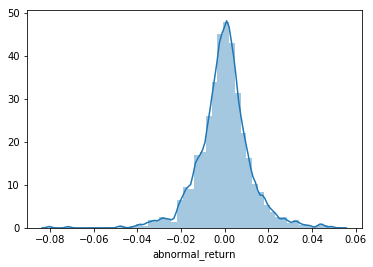

In [22]:
# check distribution of return

sns.distplot(df['abnormal_return']);

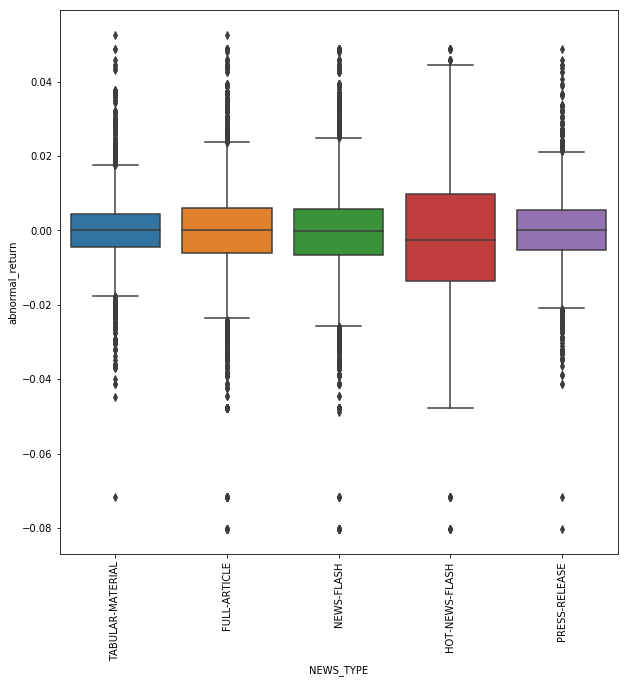

In [23]:
var_x = 'NEWS_TYPE'
var_y = 'abnormal_return'
data = pd.concat([df[var_x], df[var_y]], axis = 1)
plt.subplots(figsize = (10, 10))
fig = sns.boxplot(x = var_x, y = var_y, data = data)
plt.xticks(rotation = 90);

### Preparing data for Sklearn

In [24]:
#assigning feature matrix and output variable #change
X = df[['RELEVANCE','GROUP','ESS','AES','AEV','ENS','ENS_SIMILARITY_GAP', 'ENS_ELAPSED','G_ENS',
        'G_ENS_SIMILARITY_GAP','G_ENS_ELAPSED','NEWS_TYPE','RP_STORY_EVENT_INDEX', 'RP_STORY_EVENT_COUNT',
        'CSS','NIP','PEQ','BEE','BMQ','BAM','BCA','MCQ']]

y = df['dreturn_flag']

,RELEVANCE,ESS,AES,AEV,ENS,ENS_SIMILARITY_GAP,ENS_ELAPSED,G_ENS,G_ENS_SIMILARITY_GAP,G_ENS_ELAPSED,RP_STORY_EVENT_INDEX,RP_STORY_EVENT_COUNT,CSS,NIP,PEQ,BEE,BMQ,BAM,BCA,MCQ,GROUP_acquisitions-mergers,GROUP_analyst-ratings,GROUP_assets,GROUP_balance-of-payments,GROUP_bankruptcy,GROUP_civil-unrest,GROUP_corporate-responsibility,GROUP_credit,GROUP_credit-ratings,GROUP_crime,GROUP_dividends,GROUP_earnings,GROUP_equity-actions,GROUP_exploration,GROUP_indexes,GROUP_industrial-accidents,GROUP_insider-trading,GROUP_investor-relations,GROUP_labor-issues,GROUP_legal,GROUP_marketing,GROUP_order-imbalances,GROUP_partnerships,GROUP_pollution,GROUP_price-targets,GROUP_products-services,GROUP_regulatory,GROUP_revenues,GROUP_security,GROUP_stock-prices,GROUP_taxes,GROUP_technical-analysis,GROUP_transportation,NEWS_TYPE_FULL-ARTICLE,NEWS_TYPE_HOT-NEWS-FLASH,NEWS_TYPE_NEWS-FLASH,NEWS_TYPE_PRESS-RELEASE,NEWS_TYPE_TABULAR-MATERIAL
12,100,41.0,29,65,100.0,12.12536,0.0,100.0,12.12536,0.0,1,1,52,70,50,50,100,50,50,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
# transform nominal features to dummy features
X = pd.get_dummies(X)

In [27]:
# check correlation of all variables
#corrmat = df.corr()
#plt.subplots(figsize = (15, 15))
#sns.heatmap(corrmat, vmax = 0.75, square = True, annot = True, fmt='.2f');

# visualize relationship between the most correlated variables

#cols = corrmat.nlargest(5, 'dvol')['dvol'].index
#sns.pairplot(df[cols])
#plt.show()

## Model Selection

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     random_state=0, 
                     stratify=y)
X_train.shape, X_test.shape

((31909, 58), (10637, 58))

### Assessing feature importance with Random Forests

In [65]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = X.columns[0:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]


from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of samples that meet this criterion:', 
      X_selected.shape[0])

for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

Number of samples that meet this criterion: 29782
 1) AEV                            0.174093
 2) AES                            0.140095
 3) G_ENS_SIMILARITY_GAP           0.103330


### Building Random Forest Classifier

In [78]:
## Random forest classifier constructed with 25 trees 

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25,
                                max_depth=None,
                                random_state=1,
                                n_jobs=1)
forest.fit(X_train, y_train)
#print accuraccy on the training dataset
print('Train Accuracy: %.3f' % forest.score(X_train, y_train))
#print accuracy on the test dataset
print('Test Accuracy: %.3f' % forest.score(X_test, y_test))
from sklearn import metrics

Train Accuracy: 0.998
Test Accuracy: 0.644


In [54]:
#running logistic regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

## I am not sure this is the right way to call performance scores

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.508
Recall: 0.518
F1: 0.513


In [ ]:
# compare different classifiers

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    #SVC(),
    #GaussianNB(),
    #KNeighborsClassifier()
    ]

clf_columns = [
    'Name',
    'CV Train Accuracy',
    'CV Test Accuracy',
    ]

clf_table = pd.DataFrame(columns = clf_columns)

for i, clf in enumerate(classifiers):
    
    clf_name = clf.__class__.__name__
    clf_table.loc[i, 'Name'] = clf_name
    
    pipe = make_pipeline(StandardScaler(), clf)
    
    cv = cross_val_score(clf, X, y, scoring = ['accuracy', 'precision', 'recall'], cv = 2)
    
    clf_table.loc[i, 'CV Train Accuracy'] = cv['train_score'].mean()
    clf_table.loc[i, 'CV Test Accuracy'] = cv['test_score'].mean()

clf_table.sort_values(by = ['CV Test Accuracy'], ascending = False, inplace = True)
clf_table, cv

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=5),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(lr.coef_)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

[[-0.14661019  0.01734798 -0.06385672  0.00057042  0.00310551  0.01767774
   0.01711835 -0.05525877  0.00406741 -0.05512987 -0.08024646 -0.00185504
   0.0450748  -0.03281989  0.02433204 -0.03935284  0.03108256  0.01927582
  -0.03688373  0.02239044  0.03822189 -0.03523752 -0.01296501 -0.05200268
   0.05357941  0.05236494  0.00974916 -0.01412944  0.00667845  0.09083273
   0.01617727 -0.0277833  -0.01905126 -0.00944473  0.04944878  0.00204319
   0.03443883 -0.00118489 -0.00749239  0.02066226  0.01870095  0.02541951
   0.02007913 -0.07413139 -0.03127843 -0.01096998 -0.00879967 -0.03018558
  -0.00645878  0.00121908  0.05329026  0.04188478 -0.01809087  0.01089972
  -0.01999913  0.01099916 -0.00503377 -0.01295522]]
Test Accuracy: 0.507


### PCA decomposition

In [46]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)
len(eigen_vals)


Eigenvalues 
[ 4.78068298e+00  3.50399214e+00  3.00981886e+00  2.35500242e+00
  2.01912362e+00  1.80086724e+00  2.10401127e-02  8.93306519e-02
  1.04475470e-01  1.50014068e+00  1.45732075e+00  1.64408612e-01
  1.98125788e-01  2.33944789e-01  2.73553804e-01  3.10435934e-01
  3.62097935e-01  4.06582582e-01 -1.18230650e-15  6.38317110e-16
  4.59051839e-01  4.97545732e-01  5.25656802e-01  5.55237349e-01
  1.28212287e+00  6.16675175e-01  6.33514339e-01  1.25599344e+00
  6.96459298e-01  7.40802383e-01  7.99364088e-01  1.17916261e+00
  8.60481362e-01  1.13130479e+00  8.98224448e-01  1.09662396e+00
  1.06678884e+00  1.05399675e+00  9.68367727e-01  9.71266469e-01
  1.03468781e+00  1.02683682e+00  1.02052949e+00  1.01291619e+00
  1.00848190e+00  1.00530242e+00  1.00415019e+00  1.00304488e+00
  1.00195529e+00  1.00135626e+00  1.00097987e+00  1.00067927e+00
  1.00045023e+00  1.00034313e+00  1.00008623e+00  1.00013435e+00
  1.00019013e+00  1.00023844e+00]


58

In [79]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

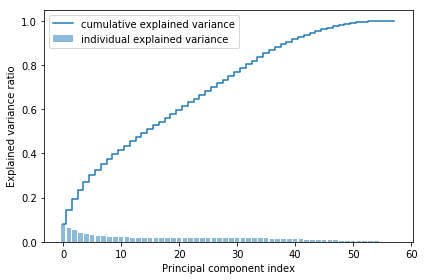

In [50]:
import matplotlib.pyplot as plt


plt.bar(range(0, 58), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(0, 58), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

## Combining transformers and estimators in a pipeline

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.505


In [58]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.5088956  0.48573347 0.50520309 0.49580396 0.49395567 0.5077233
 0.51947616 0.50470114 0.49546523 0.48740343]
CV accuracy: 0.500 +/- 0.010


### Create interaction terms

In [103]:
data=df[['ESS','AES']]
data.columns

In [114]:
from sklearn.preprocessing import PolynomialFeatures
x_t = PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(data)
x_t

array([[  41.,   29., 1189.],
       [  41.,   29., 1189.],
       [  50.,   28., 1400.],
       ...,
       [  19.,   38.,  722.],
       [  19.,   37.,  703.],
       [  19.,   36.,  684.]])